<a href="https://www.kaggle.com/code/adends/diving-deep-into-abalone?scriptVersionId=170162910" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import warnings 

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
pd.set_option('future.no_silent_downcasting', True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


# Regression with Abalone Dataset

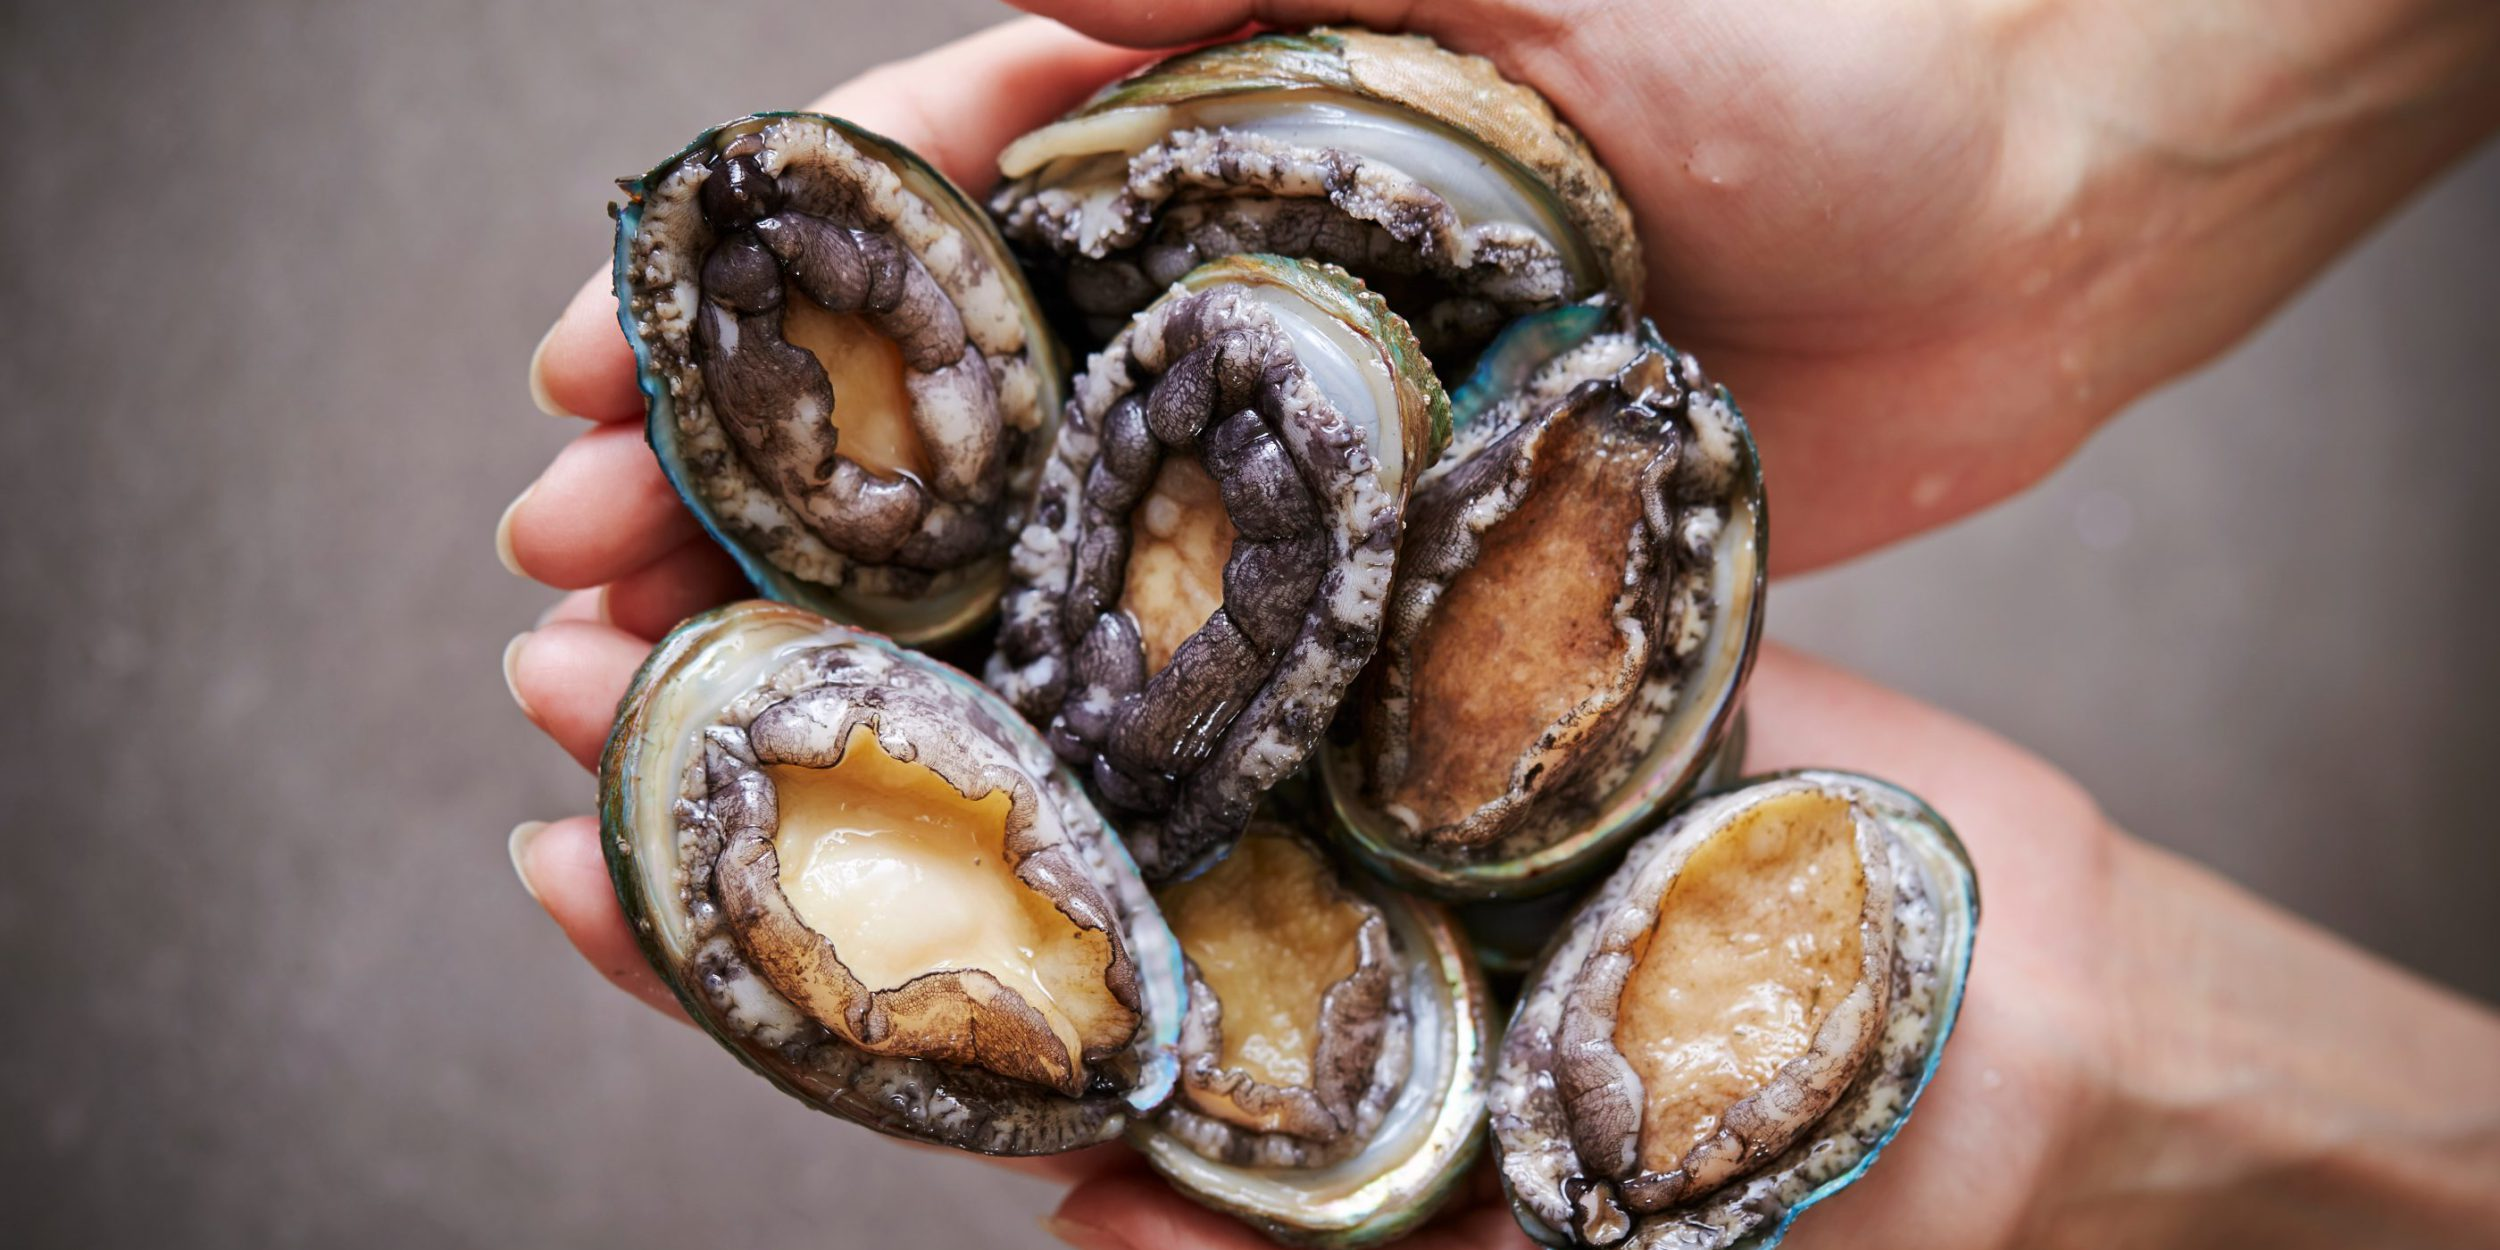

## Introduction
- ABALONE! This notebook will be going through the Abalone Dataset for the Regression with an Abalone Dataset Kaggle Competiton. This notebook will feature all the visualizations, insights, preprocessing and modeling you need to have a sucessful entry in this competiton. If you're not participating in the competition, don't worry this notebook will still offer valuable insights into dealing with data of this type. The goal for this competition is predicting the Rings (Age) of an abalone given some of it's other features.

## Dataset
https://archive.ics.uci.edu/dataset/1/abalone


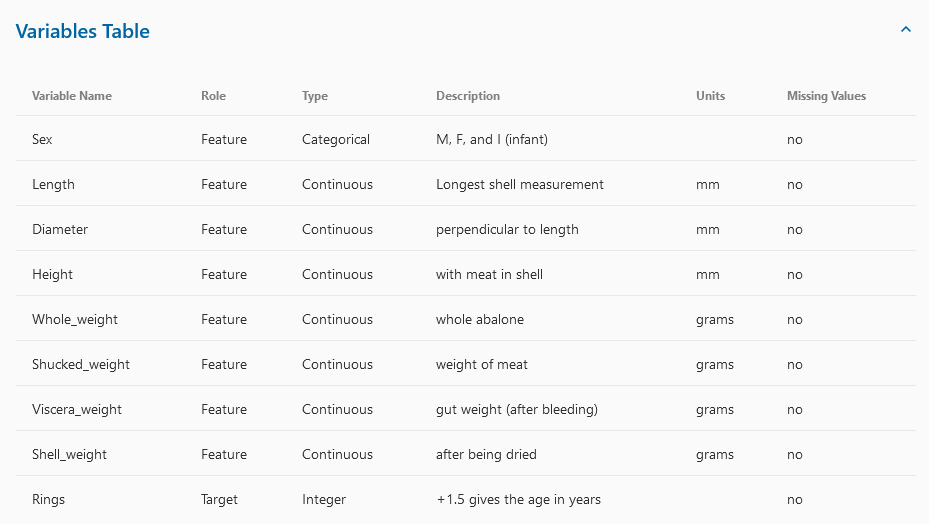



In [2]:
# Load our train and 'test' (submit) dataset
df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
df_submit = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

In [3]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


Right off the bat, the introduction gives us a quick look at the dataset's variables, offering a glimpse into their scale and type. Notably, we have the Sex column, which includes Female, Male, and Infant categories for abalones. Given it's a categorical feature, it's a good moment to start considering how we'll encode these categories for analysis.

Then, there's the weight columns, which show us the abalone's weight in different conditions, like Shell weight, Shucked weight, and so on. Just by taking a first look, it seems pretty clear these weight variables might be closely related to each other.

In [4]:
df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


This bit of analysis shows us how useful a simple summary can be. Take a look at the highest and lowest values, for example. We find out the oldest abalone in our dataset is 29 years old, and the youngest is just a year. But, it looks like a lot of them are around 9 years old – we'll plot this out to see it more clearly soon. Interestingly, there's an abalone listed with a Height of zero, which doesn't quite add up. We'll need to dig a bit deeper to figure out what's going on there

In [5]:
df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

Spotting NaN values is a critical step, and in this case, it appears the dataset is clean as promised in the introduction. But, remember when we stumbled upon that Height of 0? Those entries likely represent errors or missing information not marked as NaN. To get a clearer picture, it's essential to find out just how many entries have this issue with Height being 0. This will help us decide on our next steps, whether it’s correcting, removing, or investigating these entries further.

In [6]:
# Get all entries where Height is 0
zero_height = df.query('Height == 0')
zero_height

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
7025,7025,I,0.315,0.230,0.0,0.1340,0.0545,0.0245,0.3505,8
14208,14208,I,0.430,0.340,0.0,0.3440,0.1880,0.0705,0.1050,8
32078,32078,M,0.470,0.355,0.0,0.5785,0.2965,0.1550,0.1360,7
52324,52324,I,0.315,0.230,0.0,0.1340,0.0530,0.0375,0.3505,7
70295,70295,I,0.430,0.340,0.0,0.4060,0.2035,0.0960,0.1230,7
90295,90295,M,0.430,0.325,0.0,0.3335,0.1350,0.0585,0.1050,10


Discovering that the entries with a Height of 0 are likely errors and that these abalones tend to be within similar age ranges is a valuable insight. It suggests a pattern that could guide us in dealing with these inaccuracies. Given that the age of an abalone is closely related to its number of Rings (plus 1.5 equals age in years), using this relationship can be a smart way to impute the missing Height values.

We can approach this by first segmenting the abalones based on their Rings to identify the typical Height range for each age group. Then, calculating the median and mean Height for each group can give us a reliable estimate to fill in those zeroes. The median is particularly useful in this context, as it's less influenced by outliers and could provide a more accurate value for replacement. Let's get the stats for the relevant age group and see what the numbers tell us.

In [7]:
# Query Entries with Rings in Range (7-9)
filtered_df = df.query('Rings <= 9 and Rings >= 7')

# Get mean and median height for those entires
mean_height = filtered_df['Height'].mean()
median_height = filtered_df['Height'].median()

print("Mean Height:", mean_height)
print("Median Height:", median_height)

Mean Height: 0.12572628868495558
Median Height: 0.125


Finding out that the mean and median heights are pretty much the same is a good sign. It hints at a normal distribution for the height among our abalones. Even though this might not seem super helpful right away, it actually gives us a solid reason to lean on the median when we need to make any adjustments. So, here's the plan: we'll first clean up those zero height values by marking them as missing. Then, we'll fill in those gaps using the median height. This approach keeps our data clean and makes sure we're using a reliable measure to replace those missing bits.

In [8]:
# Replace zero values with NaN
df['Height'] = df['Height'].replace(0, np.nan)

# Fill Missing Values with Median
df['Height'] = df['Height'].fillna(value=median_height)

# Repeat for Submit Data
df_submit['Height'] = df_submit['Height'].replace(0, np.nan)
df_submit['Height'] = df_submit['Height'].fillna(value=median_height)

In [9]:
df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [10]:
# Confirm zero values are replaced
df['Height'].min()

0.004

Before diving into the charts and graphs, we've already taken a good statistical look at our dataset. Now, it's time to shift gears into visualization mode to uncover more insights. A great starting point is examining our target variable, Rings, to understand its distribution. This step will help us see the age spread of our abalones and might reveal some interesting patterns.

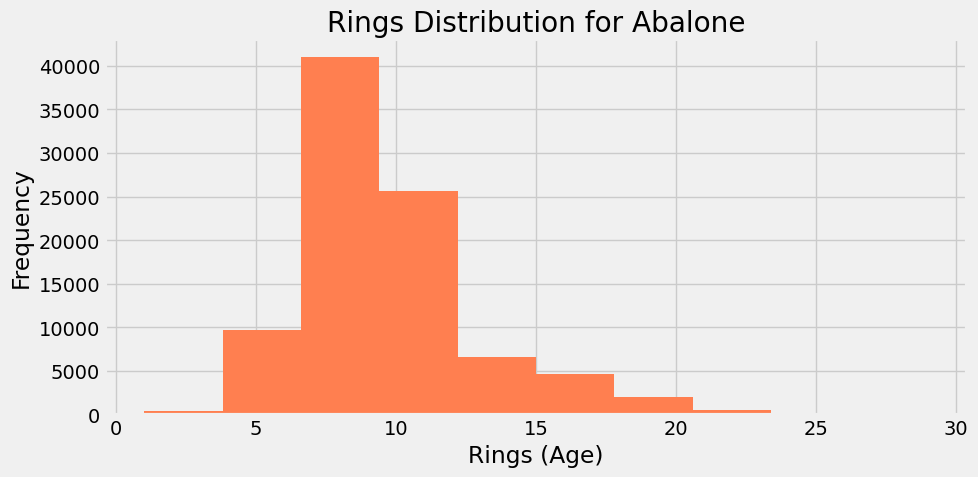

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

df['Rings'].plot(kind='hist', color='coral', ax=ax)
ax.set_xlabel('Rings (Age)')
ax.set_title('Rings Distribution for Abalone')

plt.tight_layout()
plt.show()

After checking out the graph, it's clear that the sweet spot for abalone Rings lies between 8 to 12. It's a rarity to find abalones younger than 5 Rings, but spotting ones up to 20 Rings isn't out of the ordinary. This visualization really puts into perspective how Rings, and therefore age, vary among abalones, offering us a clearer picture of their lifespan distribution.

Even though we're just getting our feet wet with visualizations, next up on our list is the Sex feature. This one's a bit different since it's categorical, meaning we'll need to prep it a bit before we can properly visualize it. With only a few unique categories to work with, One-Hot Encoding looks like our best bet here. This technique lets us transform the Sex feature into something more analysis-friendly.

How does it work? Pretty straightforward, actually. We use pandas' `get_dummies` method to create a separate column for each sex category. In these new columns, an abalone's given sex is marked with a 1, and the others are marked with 0. This way, we can easily incorporate the Sex feature into our visual analysis, making it just as insightful as the rest.

In [12]:
# One-Hot Encode Sex column for Train and Submit dataset
df = pd.get_dummies(df, columns=['Sex'], prefix='sex')
df_submit = pd.get_dummies(df_submit, columns=['Sex'], prefix='sex')

# Preview to Ensure encoded properly
df.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,sex_F,sex_I,sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,True,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,True,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,False,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,False,True,False


In [13]:
# Cast True and False as Int so we can visualize it
df[['sex_F', 'sex_I', 'sex_M']] = df[['sex_F', 'sex_I', 'sex_M']].astype(int)

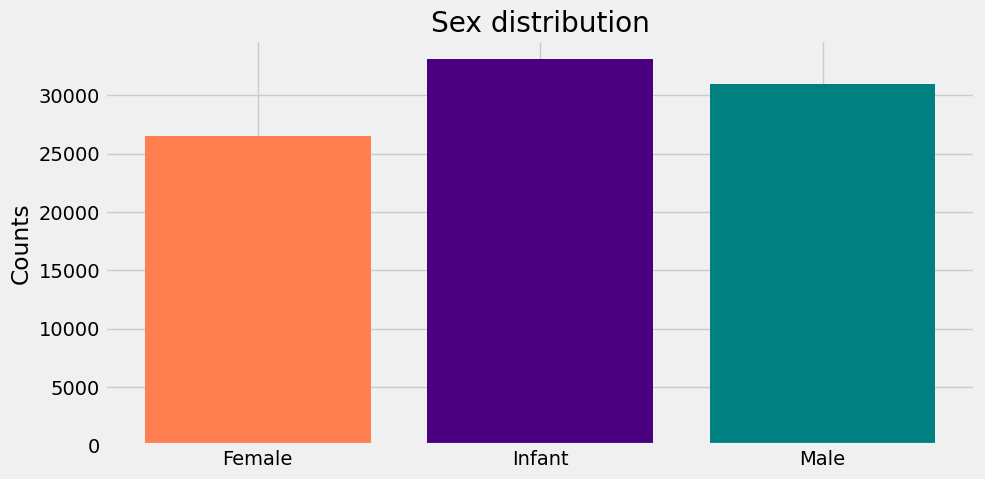

In [14]:
sex_counts = df[['sex_F', 'sex_I', 'sex_M']].sum().to_dict()

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(sex_counts.keys(), sex_counts.values(), color=['coral', 'indigo', 'teal'])

ax.set_ylabel('Counts')
ax.set_title('Sex distribution')
ax.set_xticks(range(len(sex_counts)))
ax.set_xticklabels(['Female', 'Infant', 'Male'])

plt.show()

This visualization gives us a good look at the distribution of Sex among the abalones, showing a pretty balanced split. Interestingly, the Infant category takes the lead, with Male and Female categories not far behind. This balance suggests that about a third of our abalones are classified as infants, highlighting a significant portion of younger abalones in our dataset. This detail could be crucial for understanding growth patterns and the overall demographic distribution of the abalone population we're studying.

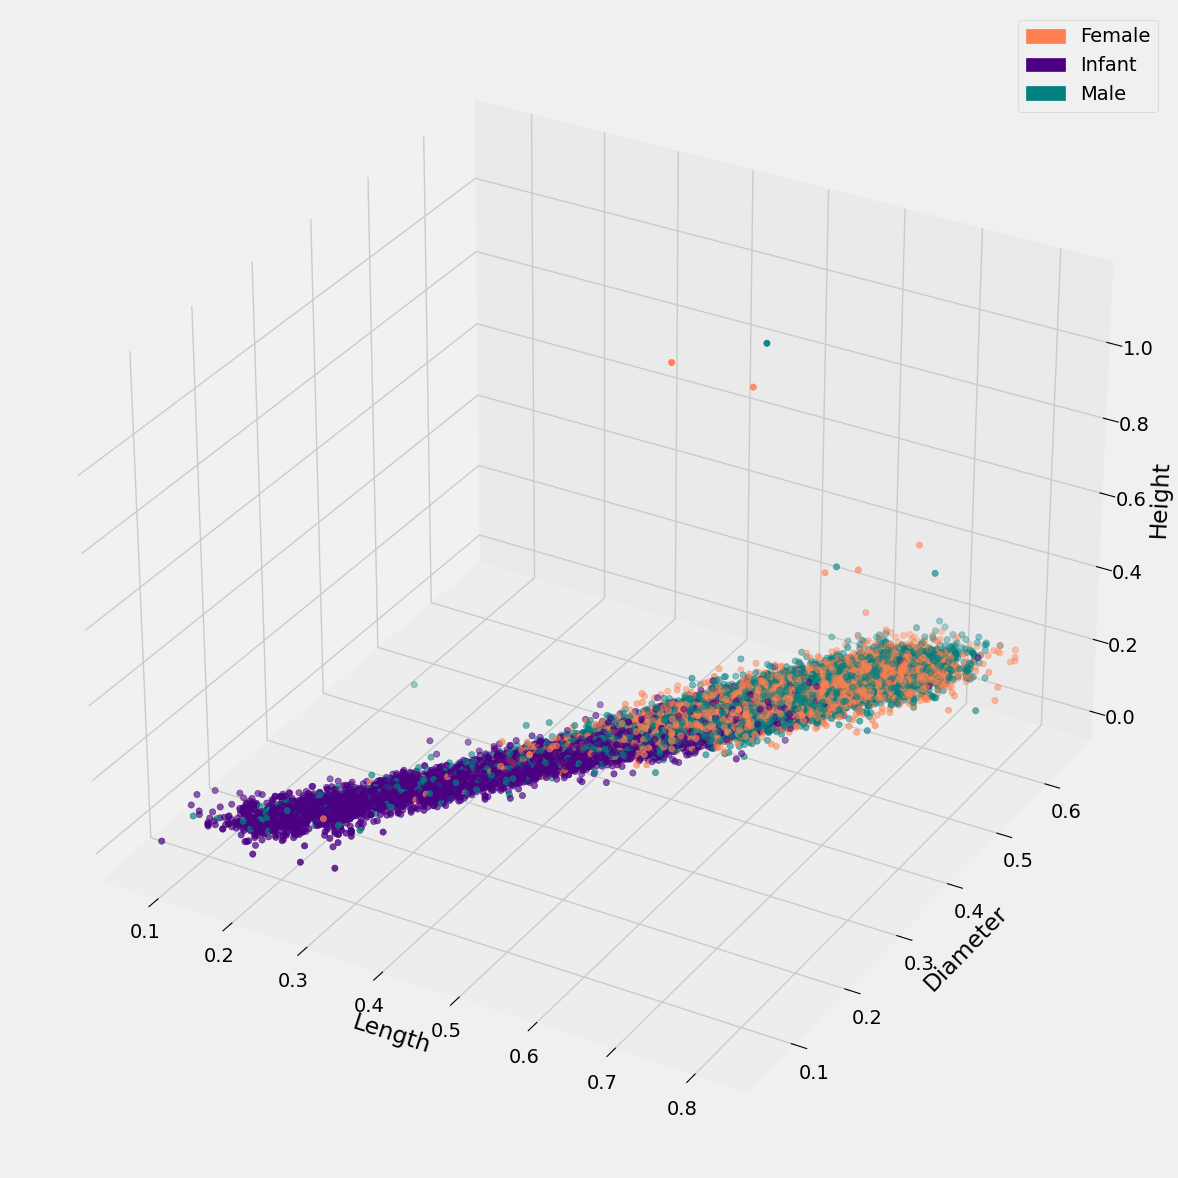

In [15]:
conditions = [
    (df['sex_F'] == 1),
    (df['sex_I'] == 1),
    (df['sex_M'] == 1)
]
choices = ['coral', 'indigo', 'teal'] 
df['color'] = np.select(conditions, choices, default='black') 

fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(111, projection='3d')

x = df['Length']
y = df['Diameter']
z = df['Height']
colors = df['color']
df = df.drop(['color'], axis=1)

ax.scatter(x, y, z, c=colors, marker='o') 

ax.set_xlabel('Length')
ax.set_ylabel('Diameter')
ax.set_zlabel('Height')
ax.legend()

legend_elements = [mpatches.Patch(color='coral', label='Female'),
                   mpatches.Patch(color='indigo', label='Infant'),
                   mpatches.Patch(color='teal', label='Male')]
ax.legend(handles=legend_elements, loc='best')

plt.tight_layout() 
plt.show()

This visualization gives us a pretty cool insight at first glance. Picture a thick line that stretches diagonally across the grid. When we notice it crossing the axis like that, it's telling us something interesting: as the Length of our subject increases, so does its Diameter. This is a classic sign of a positive correlation. Height is a bit trickier to get, but if you look closely, you'll see it also tends to go up along the line, which means it's likely positively related to Length and Diameter too.

Now, when we zoom in on how this all relates to sex, some patterns start to pop out. It seems like the Infant Abalones are generally on the smaller side, while the Male and Female ones tend to be larger. This observation could lead us down some fascinating paths of inquiry about how these features interact with each other. And yeah, there seem to be a few outliers, especially in the Height around the 0.6 to 0.8 range. We won't be removing the outliers because from my testing the removal decreases the models performance. With all this in mind, it would be a good moment to see how all of our features are correlated together.

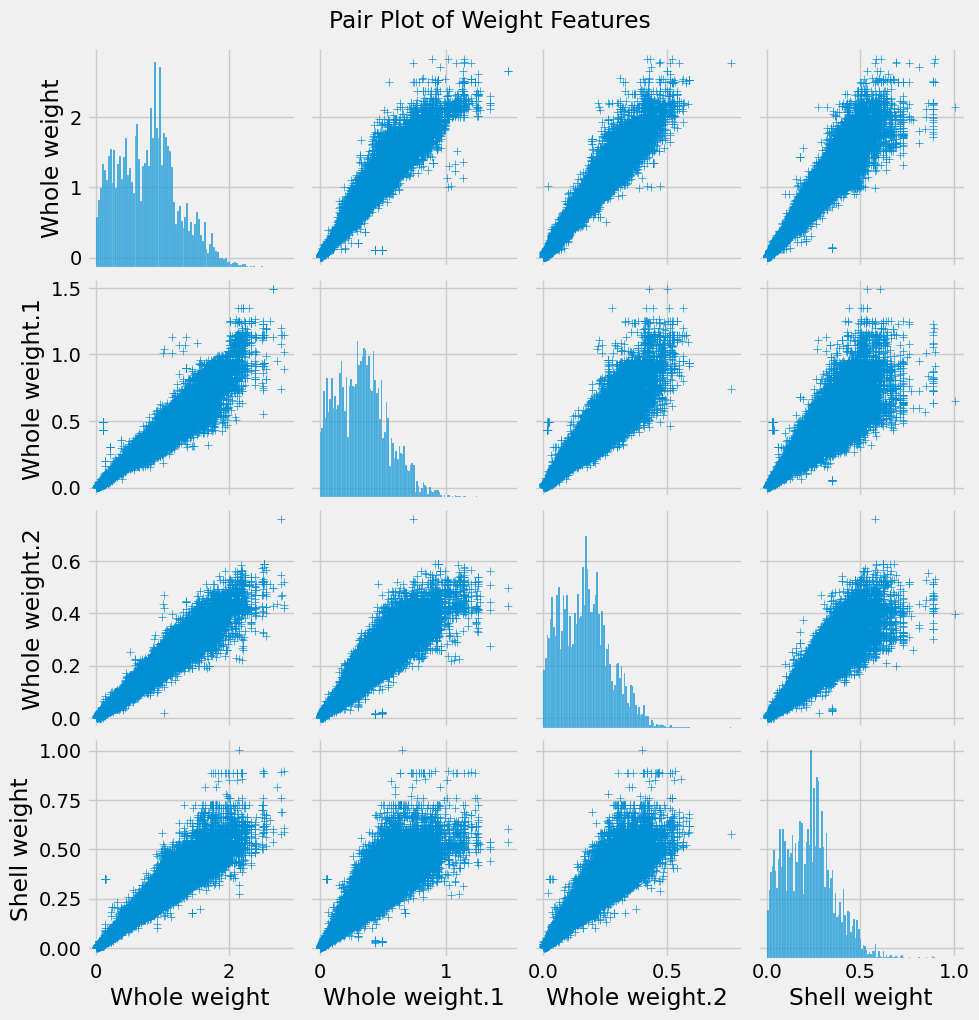

In [16]:
pair_plot = sns.pairplot(df[['Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']], markers="+")
pair_plot.fig.suptitle('Pair Plot of Weight Features', y=1.02)

plt.show()

The pair plot really opens up a window into how our weight features interact with each other. Looking at the diagonals, we notice density plots for each weight feature, revealing a pattern: they all tend to follow a right-skewed normal distribution. This skewness tells us most abalones cluster at the lower end of the scale, with fewer individuals displaying higher weights.

As for the plots off the diagonal, they're showing us how these weight variables correlate with one another. Just as we thought, there's a positive correlation across the board. This means that as one weight measure increases, the others tend to increase as well. It's fascinating to see this relationship visualized so clearly, confirming our expectations about the interconnected nature of these weight features.

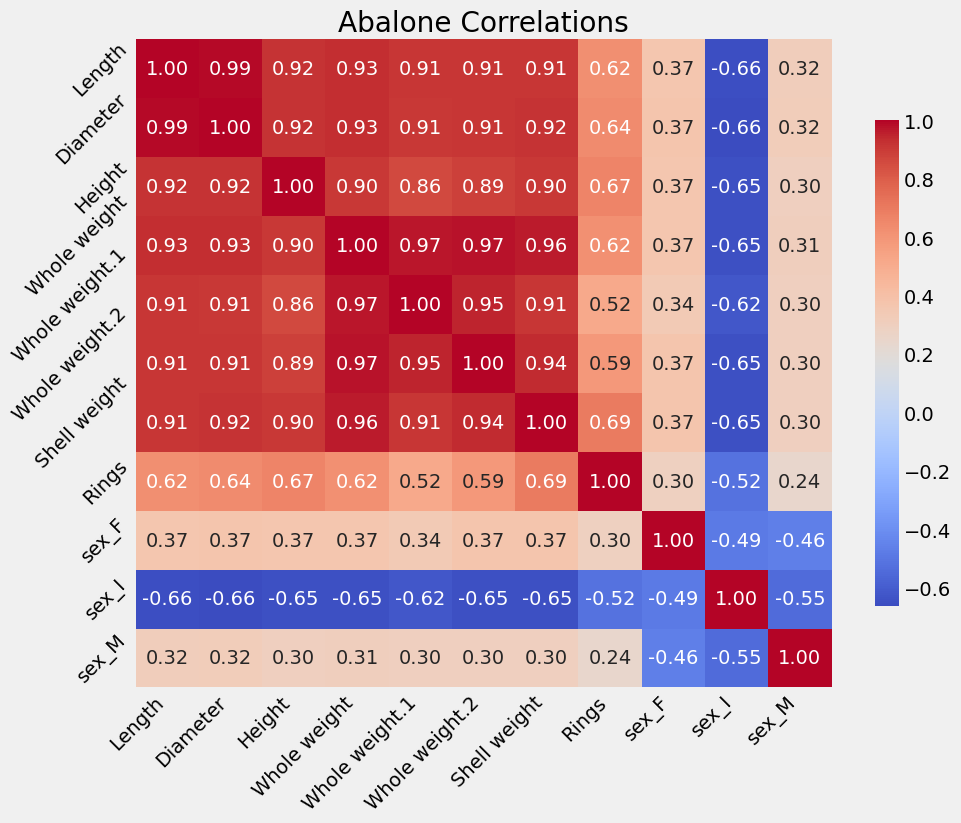

In [17]:
corr = df.drop(['id'], axis=1).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            cbar_kws={"shrink": .75})

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.title('Abalone Correlations')

plt.show()

The correlation matrix provides a comprehensive overview of the relationships between our variables, offering some expected and insightful revelations. First off, it's no surprise to see that weight and size measurements are closely intertwined, with a minimum correlation coefficient of .86. This strong positive correlation underscores the intuitive understanding that larger abalones tend to weigh more.

Interestingly, the matrix also highlights that the Infant category is negatively correlated with the size and weight variables, a nuance we glimpsed in our earlier 3D plot analysis. This suggests that younger, or infant, abalones are generally smaller and lighter compared to their adult counterparts.

Further analysis reveals that both Female and Male categories share a positive correlation with the length and weight features, though Females exhibit a slightly stronger connection. This difference may reflect subtle biological variations between the sexes in terms of growth or body composition.

Most crucially, the matrix sheds light on the relationship between Rings – our proxy for age – and other variables. There's a moderate positive correlation between Rings and all size and weight features, indicating that as abalones age, they tend to grow larger and heavier. The correlations with the Male and Female categories are weakly positive, suggesting minimal direct association between sex and age. Conversely, a moderate negative correlation with the Infant category reinforces the idea that younger abalones, by definition, have fewer Rings.

## Model Building

After thoroughly exploring our data, we're now ready to embark on the model building phase. This stage is crucial as it transforms our insights and observations into actionable predictions. Our focus will be on predicting the number of rings, which serves as an age indicator for the abalones. Here's how we'll proceed:
Quick Preprocessing

Before training our model, we need to ensure our data is in the right form. Preprocessing steps like scaling are essential, especially for algorithms that are sensitive to the scale of the input features. Scaling helps to normalize the data across all variables, ensuring that no single feature dominates the model due to its scale. With our data prepped, we'll move on to training a Gradient Boosting model. Gradient Boosting is a powerful ensemble technique that builds models in a stage-wise fashion. It's particularly good for regression tasks like ours, where we're predicting a numeric value (the number of rings). 

In [18]:
df.isna().sum()

id                0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
sex_F             0
sex_I             0
sex_M             0
dtype: int64

In [19]:
# Initialize Scaler Object
scaler = MinMaxScaler()

# Saving the Rings column
rings = df['Rings'].copy()

# Save original IDs for later use
original_ids = df['id'].copy()

# Drop 'id' and 'Rings' from dataset
feature_names = df.drop(['id', 'Rings'], axis=1).columns 

# Fit and Transform Data then assign to a new DataFrame
df_scaled = scaler.fit_transform(df.drop(['id', 'Rings'], axis=1))
df = pd.DataFrame(df_scaled, columns=feature_names)

# Re-add the 'Rings' column. Ensure rings has an index aligned with df_scaled
df['Rings'] = rings.values

# Re-add the 'id' column from the original DataFrame
df['id'] = original_ids.values

# For submit dataset
submit_ids = df_submit['id'].copy()
df_submit_scaled = scaler.transform(df_submit.drop(['id'], axis=1))
df_submit_scaled = pd.DataFrame(df_submit_scaled, columns=feature_names)
df_submit_scaled['id'] = submit_ids.values

# Reorder columns to put 'id' at the start
cols = ['id'] + [col for col in df_submit_scaled if col != 'id']
df_submit = df_submit_scaled[cols]

In this step, we're focusing on scaling our data, an essential part of preprocessing. We're using the MinMaxScaler, which essentially shrinks the range of our data to fit between a minimum and maximum value, often 0 and 1. This scaling helps our model treat all features equally, especially when their original scales vary widely.

Here’s why we’re handling the Rings and id columns specially:
- Rings Column: We're setting this aside before scaling because it's our target variable for predictions. Since the scaling adjusts data features for modeling, we don't apply it to our target.
- ID Column: This one we're keeping as is because it's just for identification. Scaling it would make no sense, as we need these IDs unchanged for tracking samples or making submissions.

In [20]:
# Define RMSLE (Root Mean Squared Logarithmic Error) calculation function
def rmsle(actual, predicted):
    return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

# Create a scorer for model evaluation using RMSLE
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Preparing the data: dropping 'id' and 'Rings' from features and setting 'Rings' as target
X, y = df.drop(['id', 'Rings'], axis=1), df['Rings']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2002)

# Setting up the parameter grid for hyperparameter tuning
param_dist = {
    'iterations': range(50, 400, 50),       # Number of training iterations
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rate for gradient descent
    'depth': range(3, 10),                  # Depth of trees
    'l2_leaf_reg': [1, 3, 5, 7, 9],         # L2 regularization on leaf weights
    'border_count': [32, 64, 128, 254],     # Number of splits for numerical features
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsampling rate for the training instances
}

# Initializing the model for randomized search with CatBoostRegressor
model = RandomizedSearchCV(
    estimator=CatBoostRegressor(silent=True, random_seed=2002), 
    param_distributions=param_dist,  # Parameter grid to search over
    n_iter=100,                      # Number of parameter settings to try
    scoring=rmsle_scorer,            # Scoring method using the custom RMSLE scorer
    cv=5,                            # 5-fold cross-validation
    verbose=1,                       # Verbose output to see the progress
    random_state=2002,               # Random seed for reproducibility
    n_jobs=-1                        # Use all available cores
)

# Fitting the model to the training data
model.fit(X_train, y_train)

# Printing the best parameters and corresponding RMSLE score
print("Best parameters found: ", model.best_params_)
print("Best score (RMSLE) found: ", model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.8, 'learning_rate': 0.3, 'l2_leaf_reg': 9, 'iterations': 250, 'depth': 6, 'border_count': 254}
Best score (RMSLE) found:  -0.15021747142297315


In the previous step, we tackled training our model, utilizing a technique known as RandomizedSearch. This method is incredibly effective for exploring different combinations of parameters to find the best fit for our model. Unlike GridSearch, which systematically works through all possible combinations and can be time-consuming, RandomizedSearch selects a random subset of parameters. This approach significantly cuts down on computation time while still providing a good shot at finding optimal settings.

A key point to remember is the caution against using GridSearch, especially in environments with time constraints, like Kaggle notebooks, which have a 12-hour limit. Due to the exhaustive nature of GridSearch, especially with complex models like ensemble methods, you risk running into timeouts. So, if you're considering a more thorough search like GridSearch, it's wise to run those experiments in a setting where you won't be limited by time constraints. RandomizedSearch offers a practical balance between efficiency and thoroughness, making it a suitable choice for fine-tuning models without the extensive time investment.

Lastly, we are using CatBoost for this iteration of the notebook, but I found XGBoost, LightGBM and CatBoost to all have similar results on this competition.

In [21]:
# Get preidctions
predictions = model.best_estimator_.predict(X_test)

# Calculate various regression metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 3.353970784742348
Root Mean Squared Error (RMSE): 1.8313849362551686
Mean Absolute Error (MAE): 1.2419457382184043
R^2 Score: 0.6623043385093986


In [22]:
# Make submission
submit_predictions = model.best_estimator_.predict(df_submit.drop(['id'], axis=1))
df_submit['Rings'] = submit_predictions
df_submit[['id', 'Rings']].to_csv('submission.csv', index=False)